In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
cd PatientTrajectoryForecasting

/home/sifal.klioui/PatientTrajectoryForecasting


In [28]:
from utils.data_preparation import (
    load_mimic_data,
    clean_data,
    icd_mapping,
    trim,
    build_data,
    remove_code,
    save_files,
    generate_code_types,
    filter_subjects,
    filter_notes
)

from utils.utils import get_paths, store_files
import yaml 
import os
import pandas as pd
from stats.plots import plot_admission_distribution

In [4]:
with open('paths.yaml', 'r') as file:
    path_config = yaml.safe_load(file)

In [5]:
paths = get_paths(path_config) 

In [6]:
subject_id_adm_map, adm_dx_map, adm_px_map, adm_drug_map, drug_description_map, notes = await load_mimic_data(**paths, load_notes = False)

Building subject_id-admission mapping, admission-date mapping
Done building subject_id-admission mapping
Building admission-diagnosis mapping
-Number of null ICD9 codes in file /home/sifal.klioui/mimic-iv-2.2/hosp/diagnoses_icd_sorted_hadim_seq_num.csv.gz: 0
-Number of null ICD10 codes in file /home/sifal.klioui/mimic-iv-2.2/hosp/diagnoses_icd_sorted_hadim_seq_num.csv.gz: 0
Done building admission-diagnosis mapping
Building admission-procedure mapping
-Number of null ICD9 codes in file /home/sifal.klioui/mimic-iv-2.2/hosp/procedures_icd_sorted_hadim_seq_num.csv.gz: 0
-Number of null ICD10 codes in file /home/sifal.klioui/mimic-iv-2.2/hosp/procedures_icd_sorted_hadim_seq_num.csv.gz: 0
Done building admission-procedure mapping
Building admission-drug mapping
Done building admission-drug mapping
loading notes, this may take a while...
notes loaded


In [7]:
NUM_VISITS_PLOT = 15
MIN_VISITS = 2

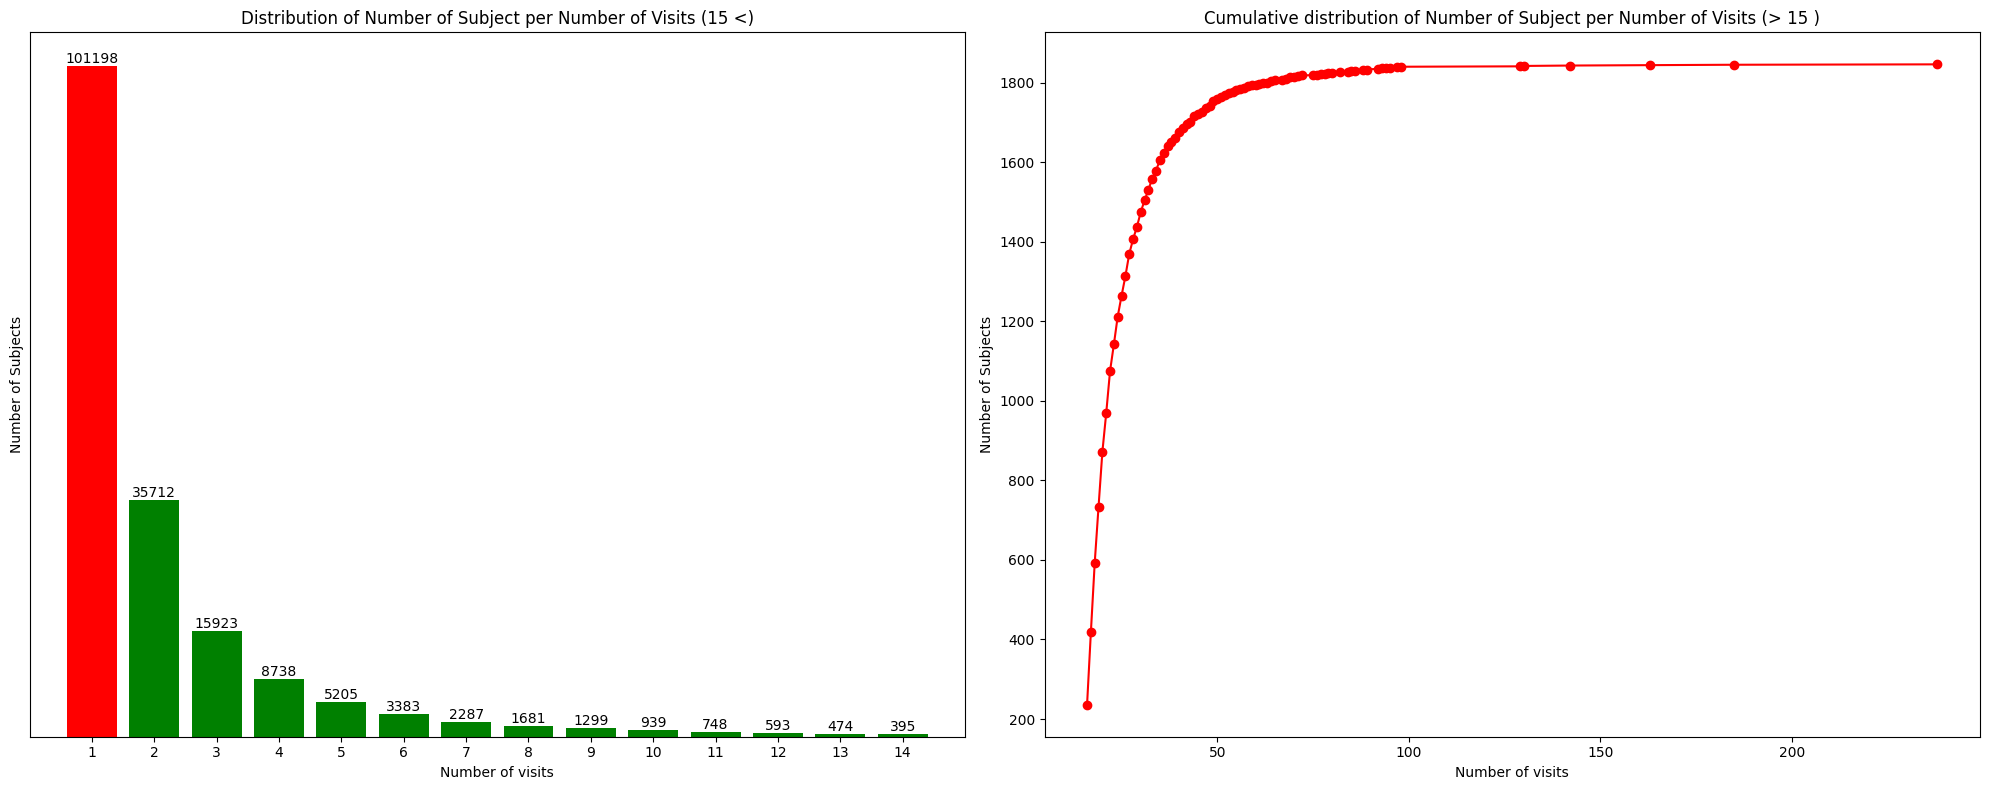

In [8]:
# Count the number of admissions per subject
plot_admission_distribution(subject_id_adm_map, save = True, num_visits = NUM_VISITS_PLOT, prefix = 'step_1')

In [9]:
subject_id_adm_map, adm_dx_map, adm_px_map, adm_drug_map = clean_data(subject_id_adm_map, adm_dx_map, adm_px_map, adm_drug_map, MIN_VISITS)

Cleaning data...
Removing patient records who do not have all three medical codes for an admission
Removing patients who made less than 2 admissions
- Total Number of diagnosis code 15763
- Total Number of procedure code 8482
- Total Number of drug code 1609
- Total Number of all codes 25854
- Average Number of procedure codes per visit: 3.03 +- 2.81
- Average Number of diagnosis codes per visit: 12.51 +- 7.67
- Average Number of Drug codes per visit: 24.12 +- 28.19
- Min. and max. Number of diagnosis code per admission (1, 39)
- Min. and max. Number of procedure code  per admission(1, 41)
- Min. and max. Number of drug code  per admission (1, 682)


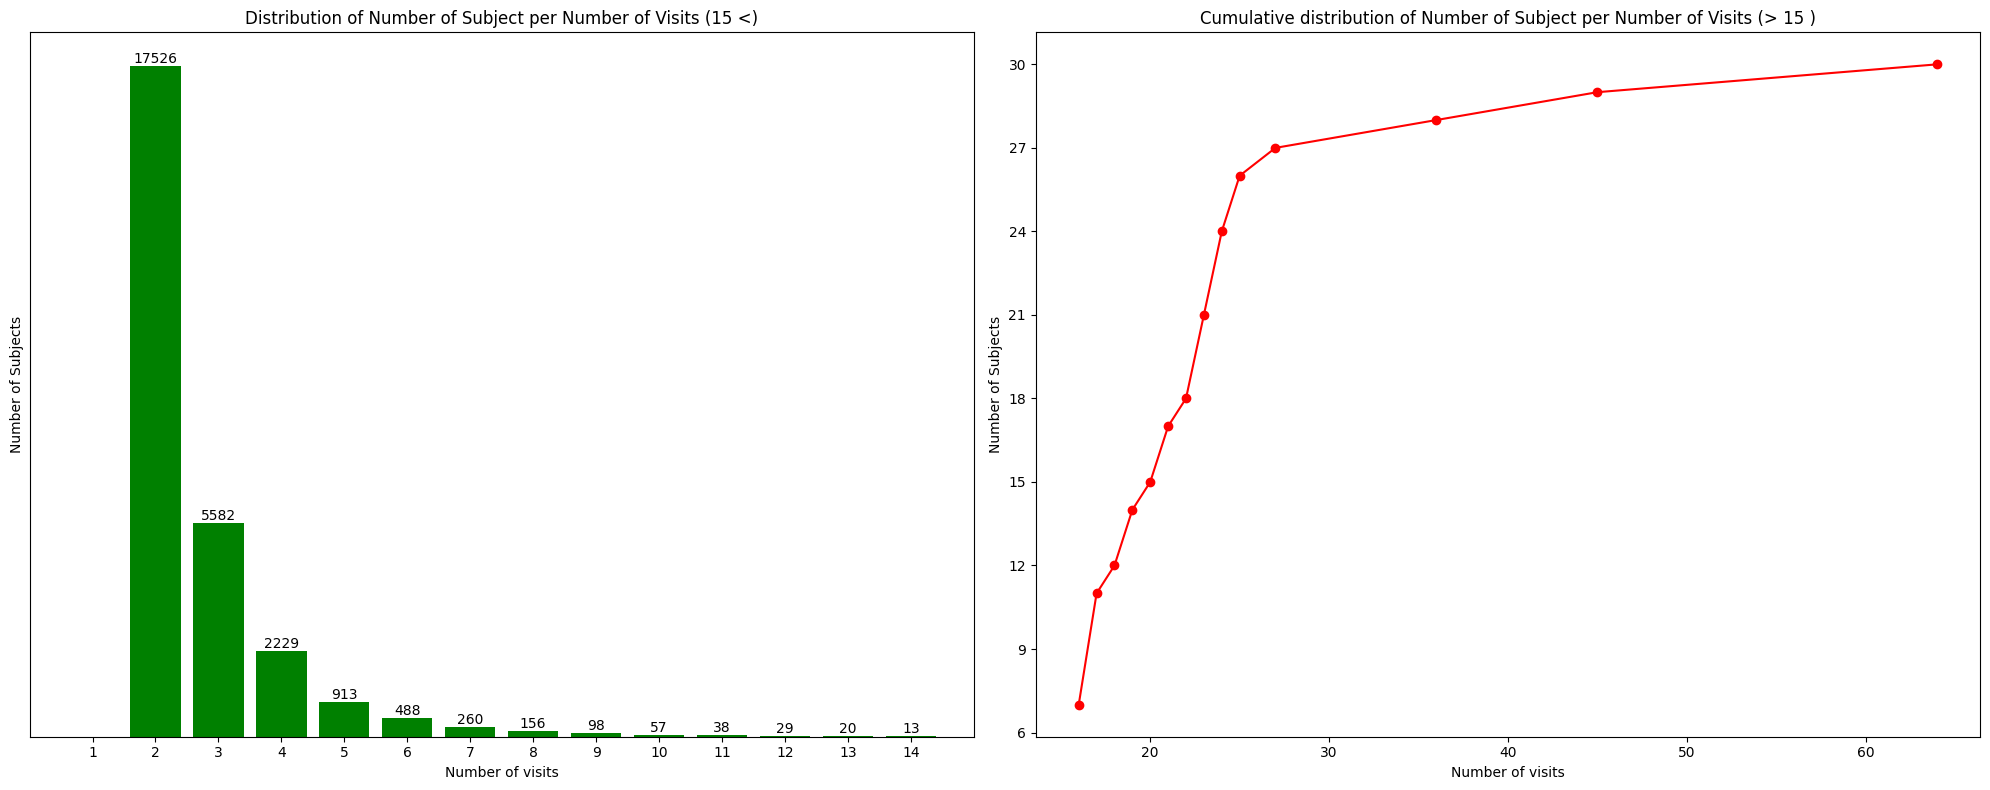

In [10]:
plot_admission_distribution(subject_id_adm_map, save = True, num_visits = NUM_VISITS_PLOT, prefix = 'step_2')

In [11]:
adm_dx_map, adm_px_map, code_description_map, _, __ = icd_mapping(adDx = adm_dx_map, adPx = adm_px_map, adDrug = adm_drug_map, drugDescription = drug_description_map, **paths)

Total ICD to CCS entries: 175715
Total CCS codes/descriptions: 514
Total number of unique codes (Diag + Proc): 883
creating diagnosis code description...
creating procedure code description...


/home/sifal.klioui/.local/lib/python3.11/site-packages/openpyxl/worksheet/header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")


addmision diagnosis codes...
- Total number of ICD9 codes used 583015 and ICD10 codes: 351733
- Total number (complete set) of ICD9+ICD10 codes (diag + proc): 175715
- Total number of ICD codes missing in the admissions list:  9
addmision procedure codes...
- Total number of ICD9 codes used 153807 and ICD10 codes: 72634
- Total number (complete set) of ICD9+ICD10 codes (diag + proc): 175715
- Total number of ICD codes missing in the admissions list:  0
- Total Number of diagnosis code 765
- Total Number of procedure code 515
- Total Number of drug code 1609
- Total Number of all codes 2889
- Average Number of procedure codes per visit: 3.03 +- 2.81
- Average Number of diagnosis codes per visit: 13.22 +- 8.63
- Average Number of Drug codes per visit: 24.12 +- 28.19
- Min. and max. Number of diagnosis code per admission (1, 62)
- Min. and max. Number of procedure code  per admission(1, 41)
- Min. and max. Number of drug code  per admission (1, 682)


In [12]:
max_dx, max_px, max_drg = 80, 80, 80 
adm_dx_map, adm_px_map, adm_drug_map = trim(adm_dx_map, adm_px_map, adm_drug_map, max_dx, max_px, max_drg)

Trimming the diagnosis, procedure, and medication codes for each visit
- Total Number of diagnosis code 765
- Total Number of procedure code 515
- Total Number of drug code 1593
- Total Number of all codes 2873
- Average Number of procedure codes per visit: 3.03 +- 2.81
- Average Number of diagnosis codes per visit: 13.22 +- 8.63
- Average Number of Drug codes per visit: 22.22 +- 19.27
- Min. and max. Number of diagnosis code per admission (1, 62)
- Min. and max. Number of procedure code  per admission(1, 41)
- Min. and max. Number of drug code  per admission (1, 80)


In [13]:
patients_visits_sequences, tokens_to_ids_map = build_data(subject_id_adm_map, adm_dx_map, adm_px_map, adm_drug_map)

Building subject-id, diagnosis, procedure, drugs mapping
Converting Strings Codes into unique integer, and making types


In [14]:
min_freq_codes = 5
patients_visits_sequences, tokens_ids_map, ids_tokens_map  = remove_code(patients_visits_sequences, tokens_ids_map, threshold = min_freq_codes)

 Total number of codes removed: 400  
 Total number of  unique codes : 2873  


In [29]:
save_files(patients_visits_sequences, dict(tokens_ids_map), code_description_map)

In [ ]:
code_types = generate_code_types(ids_tokens_map)